# Setup

In [1]:
import torch
import gymnasium as gym
import numpy as np
from IPython.display import clear_output
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
import common.wrappers
%matplotlib inline

ModuleNotFoundError: No module named 'common.wrappers'

In [16]:
max_frames = 5000000
batch_size = 5
learning_rate = 7e-4
gamma = 0.99
entropy_coef = 0.01
critic_coef = 0.5
env_name = 'PongNoFrameskip-v4'
no_of_workers = 16

In [3]:
if torch.cuda.is_available():
    FloatTensor = torch.cuda.FloatTensor
    LongTensor = torch.cuda.LongTensor
else:
    FloatTensor = torch.FloatTensor
    LongTensor = torch.LongTensor

In [4]:
env = common.wrappers.make_atari(env_name)
env = common.wrappers.wrap_deepmind(env, scale=True)
env = common.wrappers.wrap_pytorch(env)

# Define model

In [5]:
class Model(torch.nn.Module):
    def __init__(self, action_space):
        super(Model, self).__init__()
        # conv features input image convert to hidden layers
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=8, stride=4),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1),
            torch.nn.ReLU()
        )
        feature_size = self.features(
            torch.zeros(1, *env.observation_space.shape)).cuda().view(1, -1).size(1)
        
        # critic: d_h \to  1       V(s)
        self.critic = torch.nn.Sequential(
            torch.nn.Linear(feature_size, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1)
        )

        # actor:  d_h \to |A|
        self.actor = torch.nn.Sequential(
            torch.nn.Linear(feature_size, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, action_space),
            # remember to normalize
            torch.nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        value = self.critic(x)                  # V_{\phi}(s)
        action_distribution = self.actor(x)     # \pi_{\theta}(\cdot|s)
        return value, action_distribution
    
    def get_critic(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.critic(x)
    
    def evaluate_action(self, state, action):
        value, actor_features = self.forward(state)
        dist = torch.distributions.Categorical(actor_features)
        
        log_probs = dist.log_prob(action).view(-1, 1)

        entropy = dist.entropy().mean()    #why mean????
        
        return value, log_probs, entropy
    
    def act(self, state):
        value, actor_features = self.forward(state)

        dist = torch.distributions.Categorical(actor_features)
        
        chosen_action = dist.sample()
        
        return chosen_action.item()

# Memory

In [6]:
class Memory(object):
    def __init__(self):
        self.states, self.actions, self.true_values = [], [], []
    
    def push(self, state, action, true_value):
        self.states.append(state)
        self.actions.append(action)
        self.true_values.append(true_value)
    
    def pop_all(self):
        states = torch.stack(self.states)
        actions = LongTensor(self.actions)
        true_values = FloatTensor(self.true_values).unsqueeze(1)
        
        self.states, self.actions, self.true_values = [], [], []
        
        return states, actions, true_values

# Compute true values

In [7]:
def compute_true_values(states, rewards, dones):
    R = []
    rewards = FloatTensor(rewards)
    dones = FloatTensor(dones)
    states = torch.stack(states)
    
    if dones[-1] == True:
        next_value = rewards[-1]
    else:
        next_value = model.get_critic(states[-1].unsqueeze(0))
        
    R.append(next_value)
    for i in reversed(range(0, len(rewards) - 1)):
        next_value = rewards[i] + next_value * gamma*(1-dones[i])
        
        R.append(next_value)
        
    R.reverse()
    
    return FloatTensor(R)

# Reflection

In [2]:
def reflect(memory):
    states, actions, true_values = memory.pop_all()

    values, log_probs, entropy = model.evaluate_action(states, actions)

    advantages =  true_values - values
    critic_loss = advantages.pow(2).mean()

    # see here when we compute the actor's loss, we detach the advantage function.
    # because
    actor_loss = -(log_probs * advantages.detach()).mean()

    total_loss = (critic_coef * critic_loss) + actor_loss - (entropy_coef * entropy)

    optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
        
    return values.mean().item()    

# Worker

In [9]:
class Worker(object):
    def __init__(self, env_name):
        self.env = common.wrappers.make_atari(env_name)
        self.env = common.wrappers.wrap_deepmind(self.env, scale=True)
        self.env = common.wrappers.wrap_pytorch(self.env)
        self.episode_reward = 0
        self.state = FloatTensor(self.env.reset())
        
    def get_batch(self):
        states, actions, rewards, dones = [], [], [], []
        for _ in range(batch_size):
            action = model.act(self.state.unsqueeze(0))
            next_state, reward, done, _ = self.env.step(action)
            self.episode_reward += reward

            states.append(self.state)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            
            if done:
                self.state = FloatTensor(self.env.reset())
                data['episode_rewards'].append(self.episode_reward)
                self.episode_reward = 0
            else:
                self.state = FloatTensor(next_state)
                
        values = compute_true_values(states, rewards, dones).unsqueeze(1)
        return states, actions, values

# Plot data

In [10]:
def plot(data, frame_idx):
    clear_output(True)
    plt.figure(figsize=(20, 5))
    if data['episode_rewards']:
        ax = plt.subplot(121)
        ax = plt.gca()
        average_score = np.mean(data['episode_rewards'][-100:])
        plt.title(f"Frame: {frame_idx} - Average Score: {average_score}")
        plt.grid()
        plt.plot(data['episode_rewards'])
    if data['values']:
        ax = plt.subplot(122)
        average_value = np.mean(data['values'][-1000:])
        plt.title(f"Frame: {frame_idx} - Average Values: {average_value}")
        plt.plot(data['values'])
    plt.show()

# Gather experience

In [11]:
model = Model(env.action_space.n).cuda()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, eps=1e-5)
memory = Memory()
workers = []
for _ in range(no_of_workers):
    workers.append(Worker(env_name))
frame_idx = 0
data = {
    'episode_rewards': [],
    'values': []
}

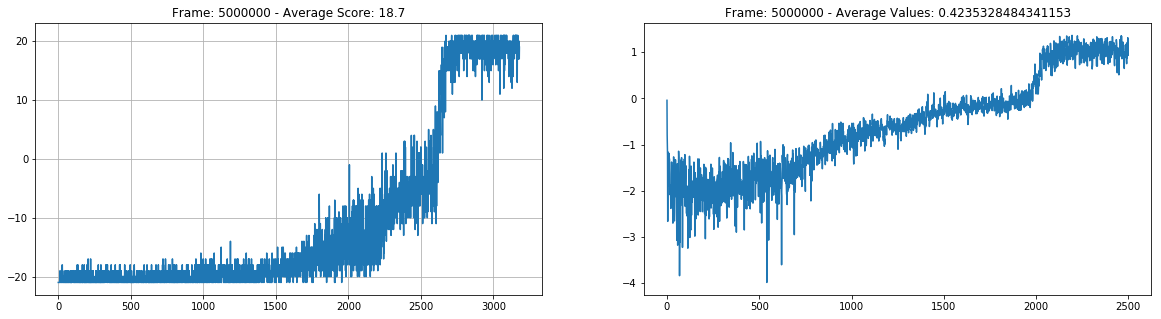

In [17]:
%debug
state = FloatTensor(env.reset())
episode_reward = 0
while frame_idx < max_frames:
    for worker in workers:
        states, action_distribution, true_values = worker.get_batch()
        for i, _ in enumerate(states):
            memory.push(
                states[i],
                action_distribution[i],
                true_values[i]
            )
        frame_idx += batch_size
        
    value = reflect(memory)
    if frame_idx % 1000 == 0:
        data['values'].append(value)
        plot(data, frame_idx)

In [18]:
torch.save(model.state_dict(), './weights/A2C-Pong.weights')

In [14]:
model.load_state_dict(torch.load('./weights/A2C-Pong.weights'))